In [1]:
!unzip 'data.zip'

Archive:  data.zip
  inflating: data/hinglish_stopwords.txt  
   creating: data/test/
  inflating: data/test/Hindi_test_unalbelled_conll_updated.txt  
  inflating: data/test/test_labels_hinglish.txt  
   creating: data/train/
  inflating: data/train/dev_3k_split_conll.txt  
  inflating: data/train/train_14k_split_conll.txt  
  inflating: data/train/train_conll.txt  
  inflating: data/train/trial_conll.txt  


In [2]:
!pip install tensorflow
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from nltk.corpus import sentiwordnet as swn
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
import pandas as pd
import nltk
from nltk.corpus import sentiwordnet as swn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from sklearn.metrics import confusion_matrix, classification_report

# Download NLTK resources
nltk.download('punkt')
nltk.download('sentiwordnet')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


class Tweet:
    def __init__(self):
        self.uid = None
        self.content = ''
        self.sentiment = ''

def cleanTweet(tweet):
    tweet.content = re.sub(r'\_', '', tweet.content)  # remove underscores
    tweet.content = re.sub(r'…', '', tweet.content)  # remove elipses/dots
    tweet.content = re.sub(r'\.', '', tweet.content)  # remove elipses/dots
    tweet.content = re.sub(r'^RT[\s]+', '', tweet.content)  # remove RT
    tweet.content = re.sub(
        "[#@©àâ€¦¥°¤ð¹ÿœ¾¨‡†§‹²¿¸ˆ]", '', tweet.content
    )  # remove weird symbols
    tweet.content = tweet.content.split("http")[0].split('https')[0]  # remove http/https
    tweet.content = ''.join([i for i in tweet.content if not i.isdigit()])  # remove digits
    tweet.content = ''.join([word for word in tweet.content if word not in string.punctuation])  # remove punctuations
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet.content = tokenizer.tokenize(tweet.content)
    tweet.content = ' '.join([i for i in tweet.content])  # convert to string
    return tweet

def load_stop_words():
    stopwords_english = stopwords.words('english')
    stopwords_hinglish = []
    with open('data/hinglish_stopwords.txt', 'r') as fp:
        while True:
            line = fp.readline()
            if not line:
                break
            stopwords_hinglish.append(line.strip())
    return stopwords_english, stopwords_hinglish

def readFile(filename, test_data=False):
    stemmer_english = PorterStemmer()
    stopwords_english, _ = load_stop_words()
    all_tweets = []
    with open(filename, 'r', encoding="utf8") as fp:
        tweet = Tweet()
        last_one = False
        while True:
            line = fp.readline()
            if not line:
                last_one = True
            if len(line.split()) > 1 or last_one:
                if last_one or line.split()[0] == 'meta':
                    if len(tweet.content) > 0 or last_one:
                        all_tweets.append(cleanTweet(tweet))
                        if last_one:
                            break
                        tweet = Tweet()
                    tweet.uid = line.split()[1]
                    tweet.sentiment = line.split()[2] if not test_data else None
                else:
                    if line.split()[1] == "Eng":
                        if line.split()[0] not in stopwords_english:
                            tweet.content += stemmer_english.stem(line.split()[0]) + " "
                    elif line.split()[1] == "Hin":
                        tweet.content += line.split()[0] + " "
                    else:
                        tweet.content += line.split()[0] + " "
    return all_tweets


def calculate_tweet_sentiment(tweet_content):
    pos_score = 0
    neg_score = 0

    words = nltk.word_tokenize(tweet_content)
    tagged_words = nltk.pos_tag(words)

    for word, tag in tagged_words:
        wordnet_tag = get_wordnet_pos(tag)
        synsets = list(swn.senti_synsets(word, wordnet_tag))
        if synsets:
            synset = synsets[0]
            pos_score += synset.pos_score()
            neg_score += synset.neg_score()

    sentiment_score = pos_score - neg_score
    if sentiment_score > 0.1:
        return "positive"
    elif sentiment_score < -0.1:
        return "negative"
    else:
        return "neutral"

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Greens):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    classes = ['Neutral', 'Positive', 'Negative']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def show_results(y_test, y_pred):
    classification_rep = classification_report(y_test, y_pred, labels=[0, 1, 2])
    print("Classification Report:")
    print(classification_rep)

    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    support = np.sum(confusion_matrix(y_test, y_pred, labels=[0, 1, 2]), axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    print("F1 Score: ", f1)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("Support: ", support)
    print("Accuracy: ", accuracy)

    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    plot_confusion_matrix(cnf_matrix)


all_tweets = readFile(r'/content/data/train/train_conll.txt')

for tweet in all_tweets:
    tweet = cleanTweet(tweet)
    tweet.sentiment = calculate_tweet_sentiment(tweet.content)

x_train = [i.content for i in all_tweets]
y_train = [i.sentiment for i in all_tweets]


# Load actual labels for the test set
actual_labels_dict = dict()
with open(r'data/test/test_labels_hinglish.txt','r') as fp:
    line = fp.readline()
    while True:
        line = fp.readline()
        if not line:
            break
        uid, label = line.strip().split(',')
        actual_labels_dict[uid] = label

# Read and process the test tweets
all_test_tweets = readFile(r'data/test/Hindi_test_unalbelled_conll_updated.txt', test_data=True)
for tweet in all_test_tweets:
    tweet.sentiment = actual_labels_dict[tweet.uid]

# Extract features and labels for the test set
x_test = [i.content for i in all_test_tweets]
y_test = [i.sentiment for i in all_test_tweets]

# Label encode test set sentiment labels
y_test = le.transform(y_test)

# Convert test set sentiment labels to categorical format
y_test_categorical = to_categorical(y_test)

# Calculate sentiment scores for test set
x_test_sentiments = [sentiment_to_score[calculate_tweet_sentiment(tweet)] for tweet in x_test]
x_test_sentiments = np.array(x_test_sentiments, dtype=float).reshape(-1, 1)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test_sentiments, y_test_categorical)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

# Predict labels on the test data
y_pred = np.argmax(model.predict(x_test_sentiments), axis=-1)

# Decode the predicted labels
y_pred_decoded = le.inverse_transform(y_pred)

# Decode the actual labels
y_test_decoded = le.inverse_transform(y_test)

# Show classification report and confusion matrix
classification_rep = classification_report(y_test_decoded, y_pred_decoded, labels=le.classes_)
print("Classification Report:")
print(classification_rep)

cnf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=le.classes_)
plot_confusion_matrix(cnf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.26      0.31       900
           1       0.40      0.35      0.37      1100
           2       0.43      0.62      0.51      1000

    accuracy                           0.41      3000
   macro avg       0.41      0.41      0.40      3000
weighted avg       0.41      0.41      0.40      3000

F1 Score:  0.39856551631010523
Precision:  0.4066587172427569
Recall:  0.412
Support:  [ 900 1100 1000]
Accuracy:  0.412


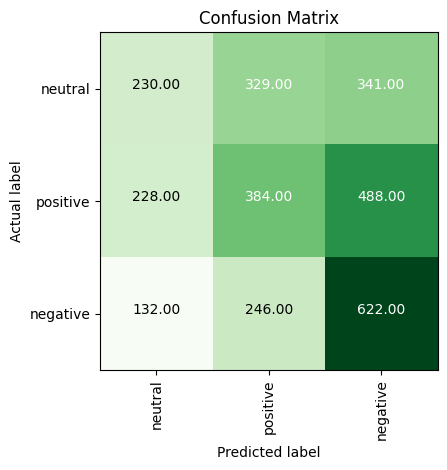

In [ ]:
# Assuming you have calculated y_test and y_pred
show_results(y_test, y_pred)
plt.show()

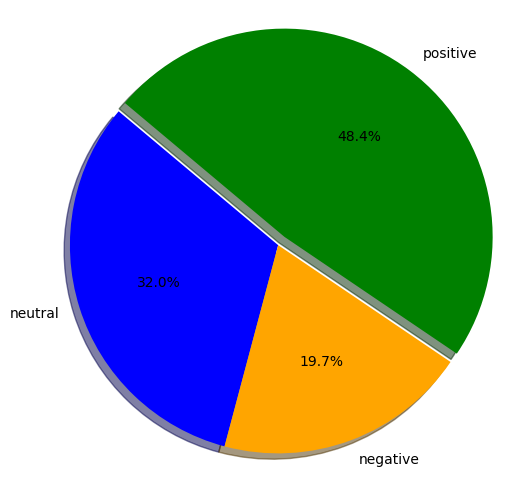

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Get the predicted sentiment labels
predicted_sentiments = le.inverse_transform(y_pred)

# Count the occurrences of each sentiment label
sentiment_counts = Counter(predicted_sentiments)

# Create a pie chart
labels = sentiment_counts.keys()
sizes = sentiment_counts.values()
colors = ['blue', 'orange', 'green']  # Colors adjusted to match the sentiment labels
explode = (0, 0.0, 0.05)  # Explode the 1st slice (positive)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Sentiment Distribution', pad=35)
plt.show()


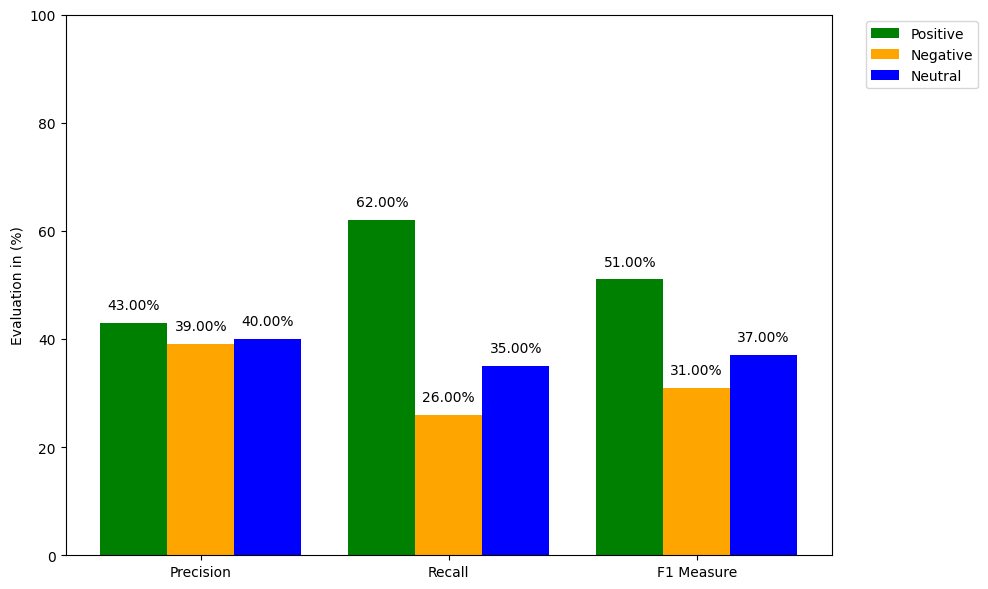

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def create_combined_bar_graph(labels, positive_scores, negative_scores, neutral_scores):
    x = np.arange(len(labels))
    width = 0.27

    plt.figure(figsize=(10, 6))

    plt.bar(x - width, positive_scores, width, label='Positive', color='green')
    plt.bar(x, negative_scores, width, label='Negative', color='orange')
    plt.bar(x + width, neutral_scores, width, label='Neutral', color='blue')

    plt.ylabel('Evaluation in (%)')
    plt.xticks(x, labels)

    # Set y-axis limit to 100
    plt.ylim(0, 100)

    # Place the legend on the outside upper right corner
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Add data values as labels on the bars
    for i, val in enumerate(positive_scores):
        plt.annotate(f'{val:.2f}%', (x[i] - width, val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(negative_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(neutral_scores):
        plt.annotate(f'{val:.2f}%', (x[i] + width, val), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.grid(False)
    plt.show()

positive_scores = [43.0, 62.0, 51.0]  # Replace with actual positive scores
negative_scores = [39.0, 26.0, 31.0]  # Replace with actual negative scores
neutral_scores = [40.0, 35.0, 37.0]   # Replace with actual neutral scores

metrics = ['Precision', 'Recall', 'F1 Measure']

# Create the combined bar graph
create_combined_bar_graph(metrics, positive_scores, negative_scores, neutral_scores)


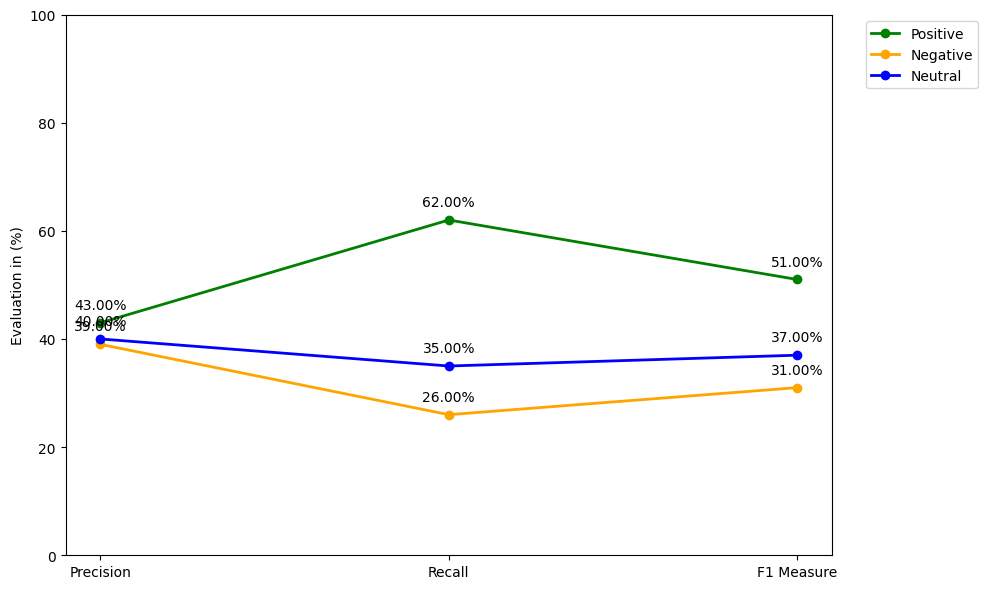

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def create_combined_line_graph(labels, positive_scores, negative_scores, neutral_scores):
    x = np.arange(len(labels))

    plt.figure(figsize=(10, 6))

    plt.plot(x, positive_scores, marker='o', label='Positive', color='green', linewidth=2)
    plt.plot(x, negative_scores, marker='o', label='Negative', color='orange', linewidth=2)
    plt.plot(x, neutral_scores, marker='o', label='Neutral', color='blue', linewidth=2)

    plt.ylabel('Evaluation in (%)')
    plt.xticks(x, labels)

    # Set y-axis limit to 100
    plt.ylim(0, 100)

    # Place the legend on the outside upper right corner
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Add data values as labels on the points
    for i, val in enumerate(positive_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(negative_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(neutral_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.grid(False)
    plt.show()

positive_scores = [43.0, 62.0, 51.0]  # Replace with actual positive scores
negative_scores = [39.0, 26.0, 31.0]  # Replace with actual negative scores
neutral_scores = [40.0, 35.0, 37.0]   # Replace with actual neutral scores


metrics = ['Precision', 'Recall', 'F1 Measure']

# Create the combined line graph
create_combined_line_graph(metrics, positive_scores, negative_scores, neutral_scores)


#Export the output file

In [ ]:
def calculate_tweet_sentiment(tweet_content):
    pos_score = 0
    neg_score = 0

    words = nltk.word_tokenize(tweet_content)
    tagged_words = nltk.pos_tag(words)

    for word, tag in tagged_words:
        wordnet_tag = get_wordnet_pos(tag)
        synsets = list(swn.senti_synsets(word, wordnet_tag))
        if synsets:
            synset = synsets[0]
            pos_score += synset.pos_score()
            neg_score += synset.neg_score()

    sentiment_score = pos_score - neg_score
    return sentiment_score


In [ ]:
import pandas as pd

# Create a list to store the data
data = []

# Process tweets and collect data
for tweet in all_tweets:
    tweet = cleanTweet(tweet)
    sentiment_score = calculate_tweet_sentiment(tweet.content)

    lem_tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokenizer.tokenize(tweet.content)]
    pos_tags = nltk.pos_tag(lem_tokens)

    sentiment_label = "positive" if float(sentiment_score) > 0.1 else ("negative" if float(sentiment_score) < -0.1 else "neutral")

    data.append({
        'uid': tweet.uid,
        'tweet': tweet.content,
        'lemmatization': ' '.join(lem_tokens),
        'pos_tags': pos_tags,
        'sentiment_score': sentiment_score,
        'sentiment_label': sentiment_label
    })

# Convert the data list into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('output.csv', index=False)


NameError: ignored